In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime 

The data contains Latin characters like å,ä,ö

In [2]:
#open the dataset
with open('../data/170829/houses.csv',encoding='latin-1') as f:
    df = pd.read_csv(f)

Get a feel for the dataset

In [3]:
df.shape

(1173, 12)

In [4]:
df.dtypes

house_type           object
address              object
region               object
area                float64
sup_area            float64
rooms               float64
land_area           float64
monthly_fee         float64
date_sold            object
broker               object
price_change_pct    float64
price                 int64
dtype: object

In [5]:
#describe the features to get a feel for the data
df.describe()

,area,sup_area,rooms,land_area,monthly_fee,price_change_pct,price
count,1161.000000,615.000000,1154.000000,915.000000,248.000000,1013.000000,1.173000e+03
mean,133.893712,48.402602,5.302860,708.743497,4732.528226,8.883514,5.728539e+06
std,40.052265,38.854796,1.463461,547.847411,1024.506335,9.621403,2.330008e+06
min,35.000000,1.500000,1.500000,101.000000,2095.000000,-16.000000,1.450000e+06
25%,108.000000,15.000000,4.000000,251.000000,4105.000000,2.000000,4.070000e+06
50%,127.000000,38.000000,5.000000,715.000000,4656.000000,8.000000,5.450000e+06
75%,157.000000,74.500000,6.000000,1018.000000,5301.000000,15.000000,7.000000e+06
max,500.000000,291.000000,14.000000,9106.000000,7993.000000,57.000000,2.117500e+07


In [6]:
df.head(5)

,house_type,address,region,area,sup_area,rooms,land_area,monthly_fee,date_sold,broker,price_change_pct,price
0,Villa,Lilla Slingan 36,Viby,155.0,NaN,6.0,1232.0,NaN,2017-08-29,Fastighetsbyrån Sollentuna,3.0,7700000
1,Radhus,Fjärdingsmansvägen 186,Norrviken,107.0,10.0,5.0,208.0,NaN,2017-08-28,Bjurfors Sollentuna,11.0,4765000
2,Villa,Dianavägen 9,Edsviken,208.0,22.0,9.0,1003.0,NaN,2017-08-28,Susanne Persson Fastighetsförmedling AB,2.0,12700000
3,Villa,Strandpromenaden 9,Norrviken,190.0,103.0,8.0,1389.0,NaN,2017-08-25,Susanne Persson Fastighetsförmedling AB,12.0,12000000
4,Villa,Valkyrievägen 9,Edsviken,198.0,91.0,7.0,1160.0,NaN,2017-08-25,Susanne Persson Fastighetsförmedling AB,1.0,12100000


In [7]:
df.count()

house_type          1173
address             1172
region              1162
area                1161
sup_area             615
rooms               1154
land_area            915
monthly_fee          248
date_sold           1173
broker              1173
price_change_pct    1013
price               1173
dtype: int64

We have a lot of missing values, some bad data, and a few unneccessary columns

- **Unnamed:** just an index column
    - id: we really dont need this for later, but for now, rename so we can use it to easily remove unique items 

- **house_type:** type of house
    - category: Villa/Radhus

- **address:** address of sold house
    - string value
    - one missing value
    - also noticed on inspection some weird values like "inställd"

- **region:** region where the house is 
    - category
    - this data is messy, need to consolidate to fewer regions
    - missing values can be inferred from address

- **area:** house area in sq metres
    - numeric, continuous
    - some missing values, seems like an important feature so may scrap rows with missing values

- **sup_area:** auxiliary area in sq metres
    - numeric, continuous
    - some missing values, these should probably be 0

- **rooms:** # rooms in the house
    - numeric, discrete
    - some missing values, maybe we can estimate from area

- **land_area:** land area in sq metres
    - numeric, continuous
    - some missing values, only houses with no listing_fee seem to have values which makes sense since you don't own the property when you have a monthly_fee (condominium), we can set this to 0 for now, but should probably categorize this

- **listing_fee:** montly fee in kr (for condominium/bostadsrätt)
    - numeric, contiuous
    - some missing values, set to 0, this is normal, if it is not a condominium you dont have a listing fee, could be used to categorize though

- **date_sold:** the date the house was sold
    - date
    - later we should probably split this up to see seasonality

- **broker** the broker firm that sold the house
    - string, category
    - no missing values
    - could be interesting to see if some broker firms have "lockpriser", i.e. if the sales price is much higher than the list price
    - could also partially gleen from this if the house is new construction (but not for sure)

- **price_change_pct:** how many percent this price went up or down from the listing price
    - numeric, continuous
    - pos/neg
    - missing values are likely 0s

- **price:** this is the price in thousand kr that the house sold for
    - numeric, continuous
    - no missing values
    - this is our target value

## Numeric values

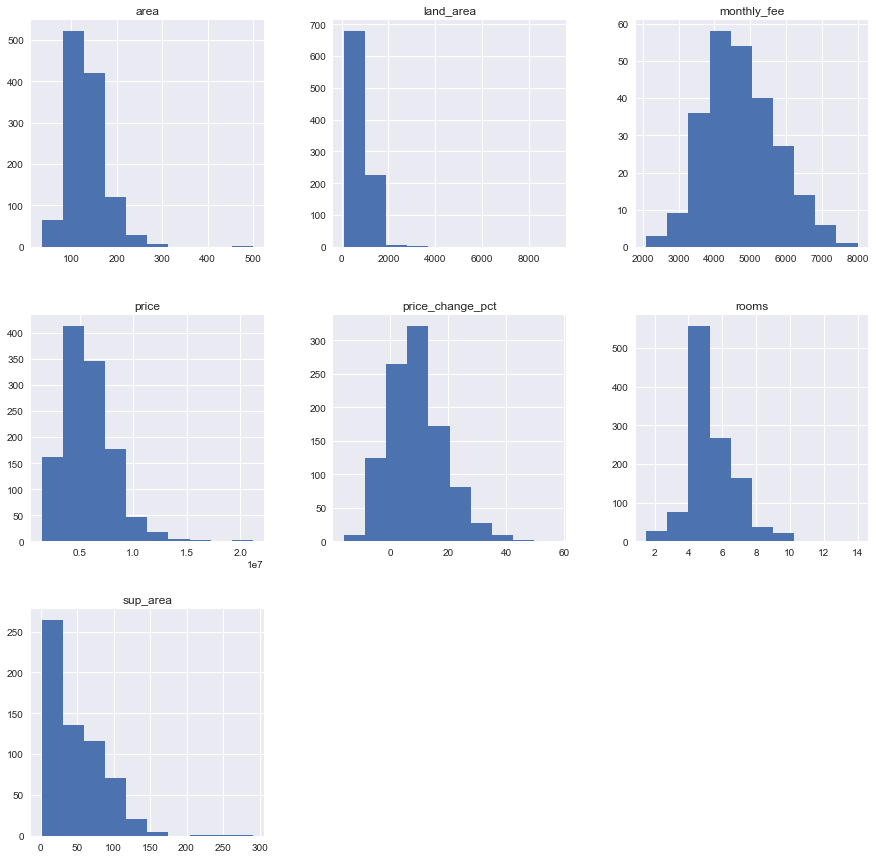

In [8]:
df.hist(figsize=(15,15))
plt.show()

In [9]:
def scatter_vs_price(var):
    data = pd.concat([df['price'], df[var]], axis=1)
    fig, ax = plt.subplots(figsize=(14,10))
    data.plot.scatter(x=var, y='price', ylim=(0,25000000), ax=ax);
    plt.show()

## Area

Area is strongly correlated with price

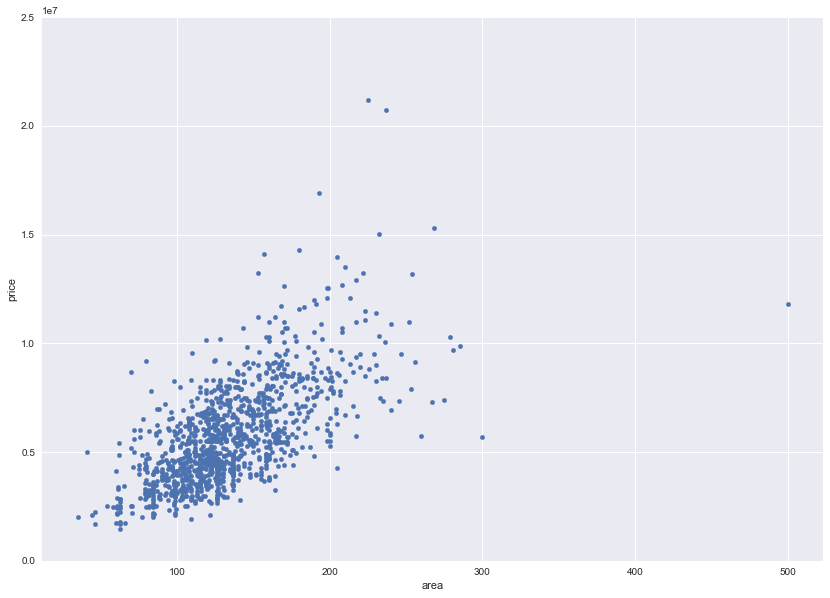

In [10]:
scatter_vs_price('area')

In [11]:
df['area'].count()

1161

In [12]:
df[df.area > 450]

,house_type,address,region,area,sup_area,rooms,land_area,monthly_fee,date_sold,broker,price_change_pct,price
616,Villa,Edsviksvägen 76B,Edsviken,500.0,NaN,14.0,1454.0,NaN,2015-08-12,Svensk Fastighetsförmedling,-9.0,11800000


This sale is odd (not representative) so it will skew our data.  A house in Edsviken (most expensive area in Sollentuna) that is 500 sq m (very large) and has 14 rooms, should have been around 14-15 million.  We can see that it went down a whole 9% from its listing price - so they thought it was worth 14.5 million too - something is very wrong here, so let's remove it

### Cleanup

#### Missing values
- Remove all the instances without area - too important

#### Outliers
- Probably remove the 500 sqm house since it is odd

## Sup_area

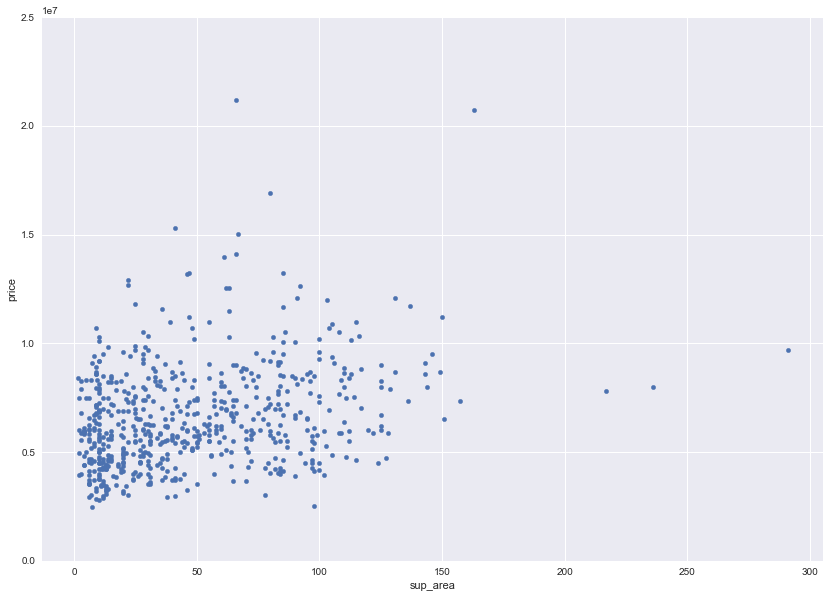

In [13]:
scatter_vs_price('sup_area')

In [14]:
df['sup_area'].count()

615

Vaguely correlated with price

### Cleanup

#### Missing values

Lots of missing values here. This is normal though if you don't have a cellar or sub-terrranian house... replace this by 0's

#### Outliers

It seems pretty odd to have over 200 sqm supplemental area.  Maybe huge cellars or garage counted... let's leave for now though

In [15]:
df[df.sup_area > 200]

,house_type,address,region,area,sup_area,rooms,land_area,monthly_fee,date_sold,broker,price_change_pct,price
284,Villa,Götavägen 33,Töjnan,207.0,217.0,6.0,1480.0,NaN,2016-09-26,Fastighetsbyrån Sollentuna,-1.0,7825000
314,Villa,Bokvägen 2A,Helenelund,159.0,236.0,8.0,1079.0,NaN,2016-09-02,Fastighetsbyrån Sollentuna,7.0,8000000
880,Villa,Mjölnarst. 4B,Centrala Sollentuna,281.0,291.0,10.0,1227.0,NaN,2014-09-15,Notar,-8.0,9700000


It would be interesting to add area + sup_area to see if that is a better indicator than the two alone

## Monthly fee

In [16]:
df['monthly_fee'].count()

248

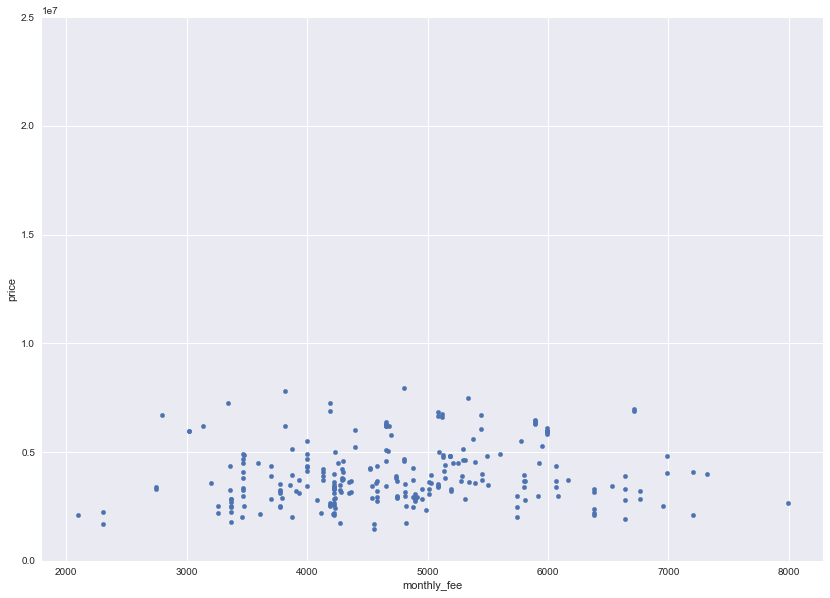

In [17]:
scatter_vs_price('monthly_fee')

Doesn't seem to have any correlation with price

## Cleanup

### Missing

Lots of missing values... this is normal though, but missing values mean that the house is not a condo, so we should set them to 0 and add an additional column "Condo" and set this to true if value is not missing...

We might even create a separate model for condos

### Outliers

Nothing to speak of

## Price_Change_Pct

This is useless for predicting the price as it is not available until the house is sold

## Land area

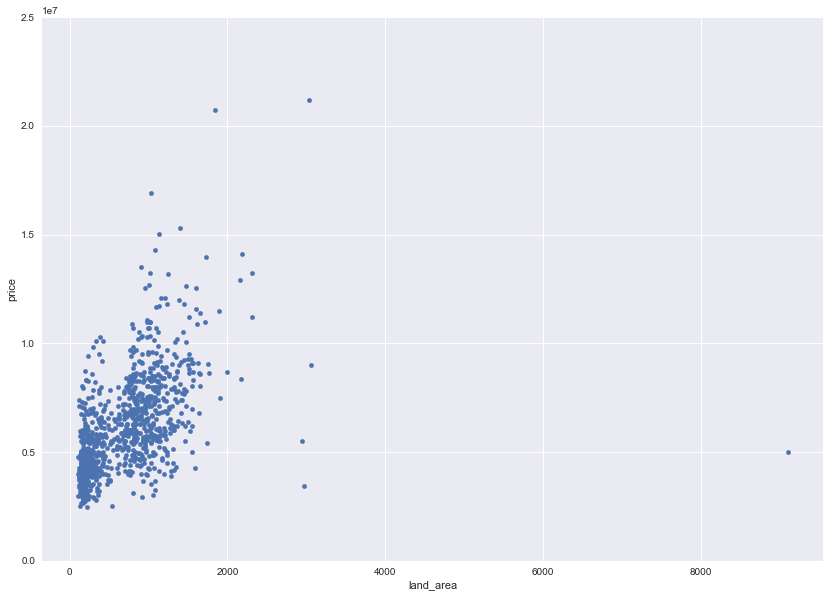

In [18]:
scatter_vs_price('land_area')

There is definitely a correlation here but some of the values dont follow the correlation.  It seems like when the land_area is over 2500 sqm we have totally different correlations...

Maybe it is best to say that our model will only work up until 2500 sqm land

Specifically the ones where land_area > 2500 and price < 6000000 seem to be way off

In [19]:
df[df.land_area > 2800]

,house_type,address,region,area,sup_area,rooms,land_area,monthly_fee,date_sold,broker,price_change_pct,price
125,Villa,Grönanvägen 2,NaN,132.0,NaN,4.0,2949.0,NaN,2017-04-02,Bjurfors Sollentuna,5.0,5500000
357,Villa,Falkbergsvägen 6,NaN,225.0,66.0,5.0,3036.0,NaN,2016-06-17,Skeppsholmen Fastighetsmäkleri AB,6.0,21175000
418,Villa,Valhallavägen 5A,Häggvik,153.0,65.0,5.0,3059.0,NaN,2016-05-02,Fastighetsbyrån Sollentuna,6.0,9000000
675,Villa,Rösjövägen 86,NaN,41.0,10.0,2.0,9106.0,NaN,2015-05-22,Svensk Fastighetsförmedling,25.0,5000000
1152,Villa,Snuggavägen 13,Törnskogen,65.0,NaN,4.0,2966.0,NaN,2013-04-26,Bjurfors Sollentuna,-7.0,3450000


Interesting... if a house is 50 or 60 sqm and has a land-area over 2500 sqm it is clearly sold for land-value... we can either remove them (because we are looking at house prices) or mark them as house_type = "land"

### Cleanup

#### Outliers

Remove houses with land > 2500 and area < 70

#### Missing values

Missing values mean this is a condo, set it to 0 (monthly fee already handles the condo piece

## rooms

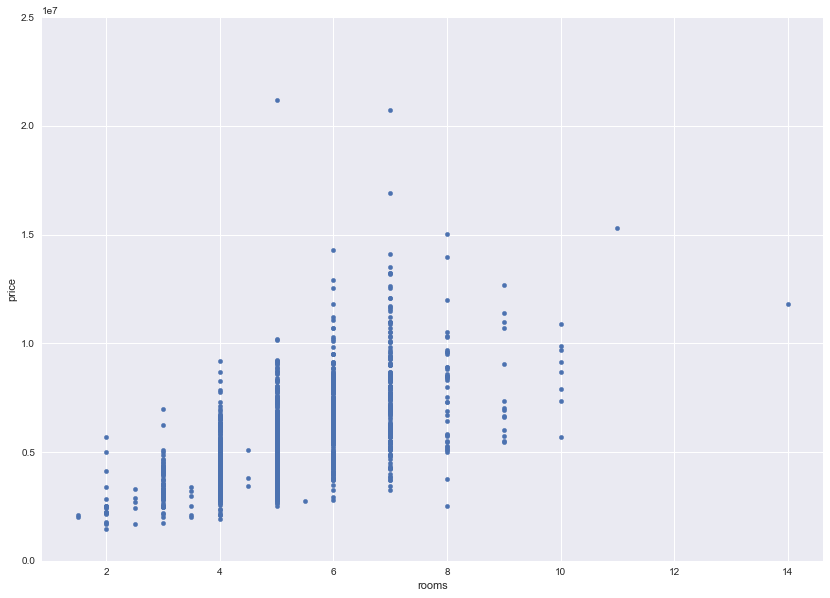

In [20]:
scatter_vs_price('rooms')

In [21]:
df['rooms'].count()

1154

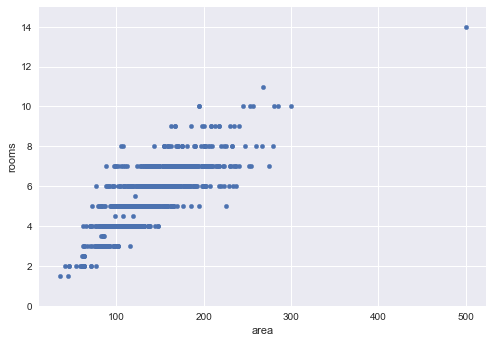

In [22]:
#let's look at room distribution to see if we can figure out approx how many rooms they should have 
#scatter plot grlivarea/saleprice
data = pd.concat([df['rooms'], df['area']], axis=1)
data.plot.scatter(x='area', y='rooms', ylim=(0,15))
plt.show()

### Cleanup

#### Missing values
We have a lot of missing values, but Rooms is highly correlated with Area so we have a couple of options

1. Remove the rooms feature (since it is so highly correlated with area)
2. Sort instances by area and "pad" the room number (i.e. give it the same as the house before in sorted order)

#### Outliers
As far as outliers go, we have a 14 room house, but it is just seems to be because the house is so big, so we'll leave it

# Categorical

## House_Type

In [23]:
df['house_type'].describe()

count      1173
unique        2
top       Villa
freq        593
Name: house_type, dtype: object

In [24]:
df.house_type.unique()

array(['Villa', 'Radhus'], dtype=object)

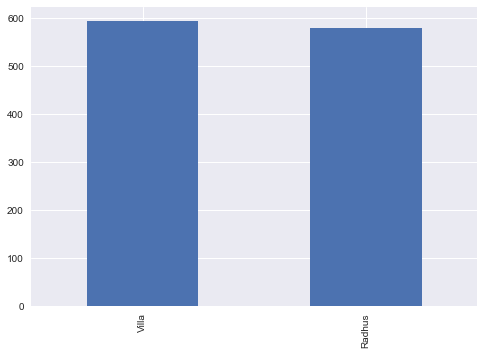

In [25]:
fig, ax = plt.subplots()
df['house_type'].value_counts().plot(ax=ax, kind='bar')
plt.show()

### Cleanup

No missing values or outliers... the balance between Villa and Radhus is extremely nice

## Region

This on the other hand is a total mess

In [26]:
df['region'].describe()

count     1162
unique      67
top       Viby
freq       189
Name: region, dtype: object

In [27]:
df.region.unique()

array(['Viby', 'Norrviken', 'Edsviken', 'Rotebro', 'Rotsunda', 'Kärrdal',
       'Töjnan', 'Silverdal', 'Gillbo', 'Häggvik', 'Fågelsången',
       'Edsberg', 'Törnskogen', 'Väsjön', 'Helenelund', 'Östra Viby',
       'Rotebro - Gillbo', 'Tureberg', 'Vaxmora', 'Edsbacka', 'Landsnora',
       'Solängen', 'Häggvik/Skälby', 'Edsberg - Landsnora', 'Edsängen',
       'Sjöberg', 'Edsberg/Landsnora', 'Södersättra', 'Kvarnskogen',
       'Tegelhagen', 'Fågelsången/Sollentuna', 'Centrala Sollentuna', nan,
       'Sollentuna Centrum', 'SOLLENTUNA', 'Centrala Tureberg', 'Skälby',
       'Tunberget', 'Helenelund/Fågelsången', 'Sollentuna - Rotsunda',
       'Falkberget', 'Sollentuna/Rotebro', 'Väsjön / Södersätra',
       'Viby Sollentuna', 'Edsberg / Landsnora', 'Rotebro/Rotsunda',
       'Sollentuna', 'Sollentuna-Sjöberg', 'Rotebro/Gillbo',
       'Gillbo Rotebro', 'Rotebro Gillberga', 'Sollentuna - Norrviken',
       'Edsviken/Hersby', 'Edsviken/Nytorp', 'Gillbo - Rotebro',
       'Hästhagen', '

In [28]:
counts = df['region'].value_counts()
counts

Viby                                       189
Norrviken                                  127
Töjnan                                      87
Helenelund                                  79
Edsviken                                    74
Häggvik                                     70
Rotebro                                     63
Fågelsången                                 51
Sjöberg                                     38
Silverdal                                   35
Rotsunda                                    34
Törnskogen                                  33
Tegelhagen                                  31
Gillbo                                      27
Tureberg                                    27
Kärrdal                                     22
Edsängen                                    22
Landsnora                                   21
Vaxmora                                     15
Solängen                                    13
Edsberg                                     12
Kvarnskogen  

### Cleanup

#### structure problems
67 different regions, many of them with only 1 house sale
Need to clean up and consolidate into regions (preferably ones that will have 50+ observations)

#### missing values
We could technically find the missing regions from addresses but for now let's just drop the ones with missing regions

## Address

This one we can just drop

## Date_sold

No missing values or outliers - but we could probably feature engineer this... like pull out the year to account for price rise due to inflation... and month for potential seasonal changes... and finally maybe mark as before or after the law about amortizations

## Broker

Here we also have a large number of unique_values - we should consolidate them

Brokers like to up-play their role and how much it affects the price... but here we also have to be careful about causality

Do certain values raise the price of the house? or 
Do certain houses attract certain realtors? 

I think we should remove the brokers alltogether

In [29]:
df['broker'].describe()

count                           1173
unique                            34
top       Fastighetsbyrån Sollentuna
freq                             383
Name: broker, dtype: object

In [30]:
counts = df['broker'].value_counts()
counts

Fastighetsbyrån Sollentuna                          383
Bjurfors Sollentuna                                 168
Mäklarhuset Sollentuna                              131
Notar                                                84
Svensk Fastighetsförmedling                          83
Susanne Persson Fastighetsförmedling AB              83
HusmanHagberg Sollentuna                             62
Länsförsäkringar Fastighetsförmedling Sollentuna     46
SkandiaMäklarna Sollentuna                           40
Svensk Fastighetsförmedling Sollentuna               19
Notar Nyproduktion AB                                14
Svenska Mäklarhuset Sollentuna                       13
ERA Mäklare i Sollentuna                             11
Erik Olsson Fastighetsförmedling                      9
Jägholm Norrortsmäklarna                              3
Karlsson & Uddare AB                                  2
Hemverket AB                                          2
Skeppsholmen Fastighetsmäkleri AB               

## Work items

- house_type:leave
- address: remove
- region: clean and consolidate, remove rows with nulls
- area: remove rows with nulls, remove > 500
- sup_area: replace null with 0
- rooms: replace nulls by padding
- land_area: replace nulls with 0, remove > 2500 where area < 70.  0 => condo = 1
- monthly_fee: replace nulls with 0
- date_sold: generate year/month
- broker: remove


# Everything below this point is just about creating plots for a presentation - ignore

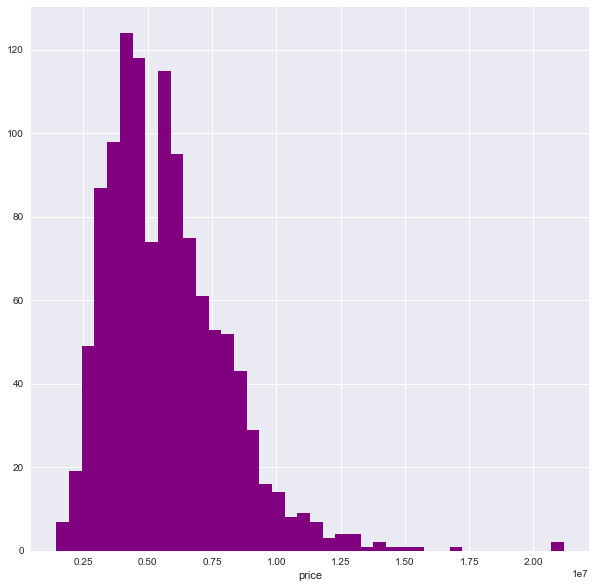

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("price")
df['price'].hist(bins=40, ax=ax, color='purple')
plt.show()

In [32]:
def box(indep_var, dep_var):
    data = pd.concat([df[dep_var], df[indep_var]], axis=1)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.boxplot(x=indep_var, y=dep_var, data=data, ax=ax)
    plt.show()

In [33]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

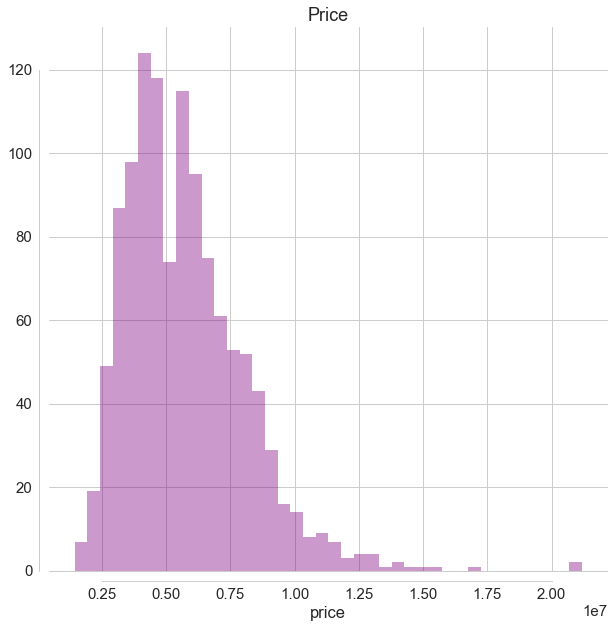

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Price")
#ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.ticklabel_format(useOffset=False)
sns.distplot(df['price'], kde=False, bins=40, ax=ax, color="purple")
sns.despine(offset=10, trim=True)
plt.show()

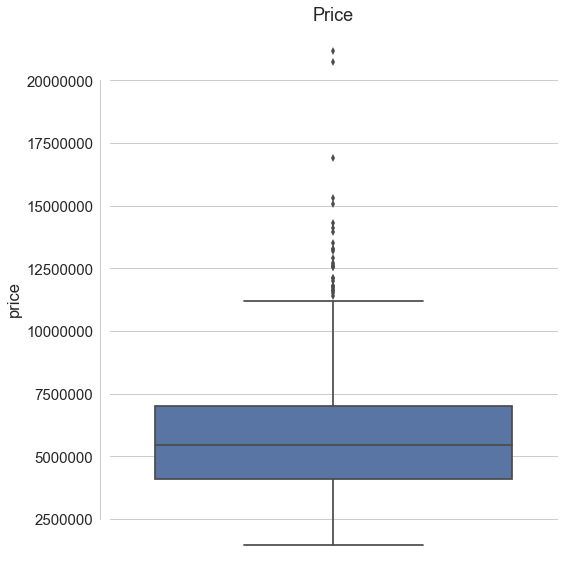

In [35]:
fig, ax = plt.subplots(figsize=(8,10))
ax.set_title("Price")
ax.get_yaxis().get_major_formatter().set_scientific(False)
#plt.ticklabel_format(useOffset=False)
sns.boxplot(y="price", data=df, ax=ax)
sns.despine(offset=10, trim=True)
plt.show()

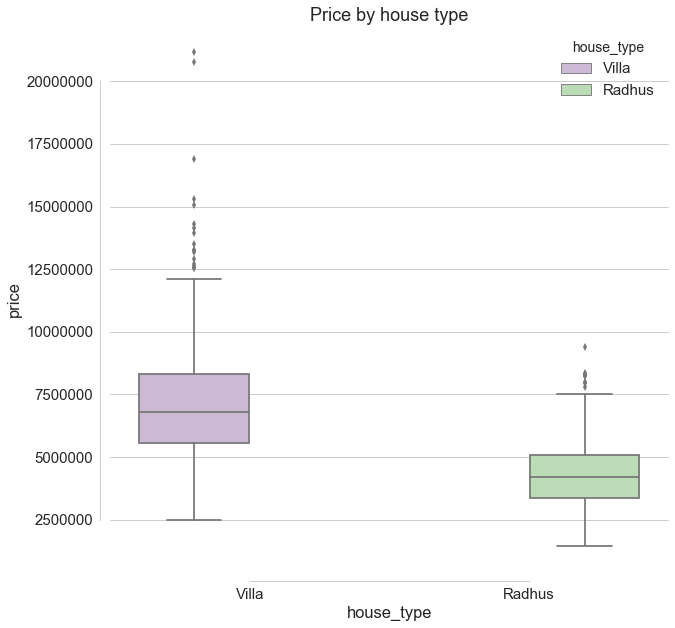

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Price by house type")
ax.get_yaxis().get_major_formatter().set_scientific(False)
sns.boxplot(x="house_type", y="price", hue="house_type", data=df, palette="PRGn", ax=ax)
sns.despine(offset=10, trim=True)
plt.show()

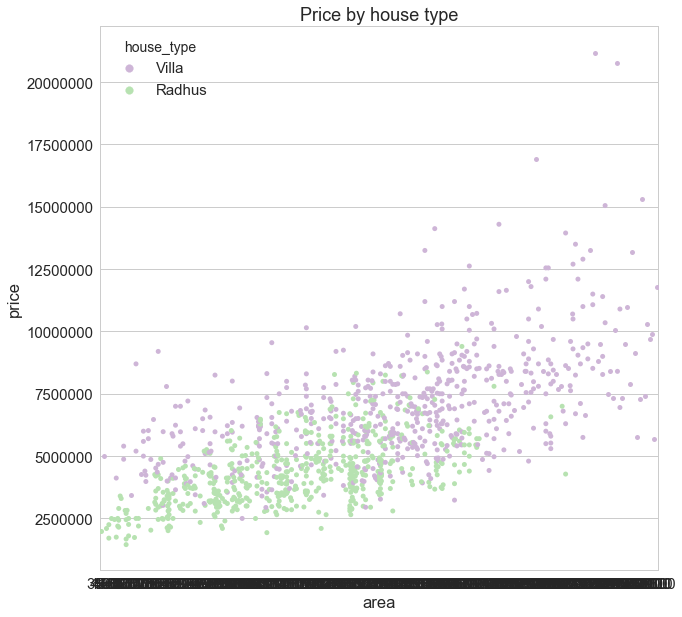

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Price by house type")
ax.get_yaxis().get_major_formatter().set_scientific(False)
sns.swarmplot(x='area', y='price', data=df, hue='house_type', palette='PRGn')
#sns.despine(offset=10, trim=True)
plt.show()

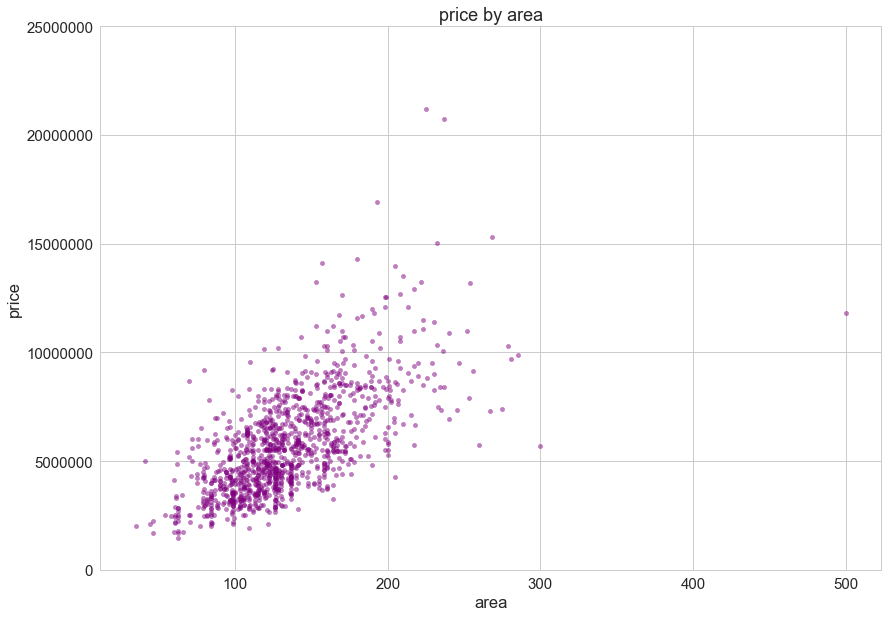

In [38]:

#    data = pd.concat([df['price'], df[var]], axis=1)
fig, ax = plt.subplots(figsize=(14,10))
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title("price by area")
df.plot.scatter(x='area', y='price', ylim=(0,25000000), ax=ax, color='purple', alpha=0.5);
plt.show()

In [39]:
df['region'].value_counts()

Viby                                       189
Norrviken                                  127
Töjnan                                      87
Helenelund                                  79
Edsviken                                    74
Häggvik                                     70
Rotebro                                     63
Fågelsången                                 51
Sjöberg                                     38
Silverdal                                   35
Rotsunda                                    34
Törnskogen                                  33
Tegelhagen                                  31
Gillbo                                      27
Tureberg                                    27
Kärrdal                                     22
Edsängen                                    22
Landsnora                                   21
Vaxmora                                     15
Solängen                                    13
Edsberg                                     12
Kvarnskogen  

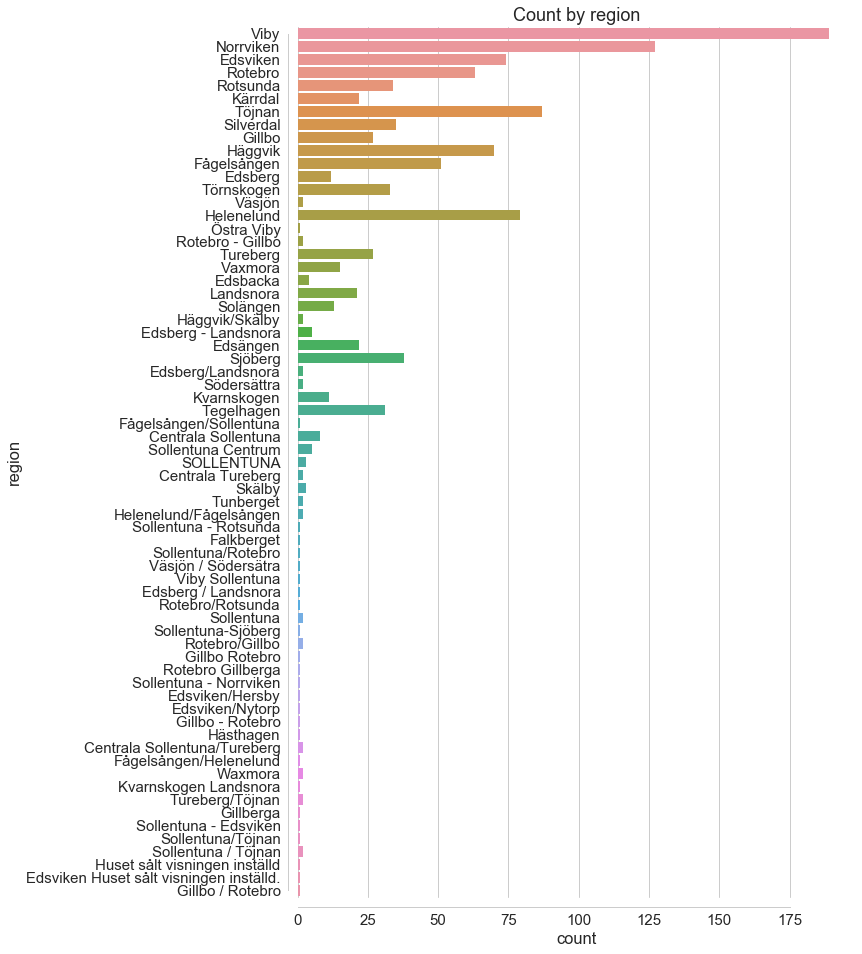

In [40]:
fig, ax = plt.subplots(figsize=(10,16))
ax.set_title("Count by region")
ax.get_yaxis().get_major_formatter().set_scientific(False)
#data = df['region'].value_counts()
sns.countplot(y='region', data=df)
sns.despine(offset=10, trim=True)
plt.show()

In [41]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

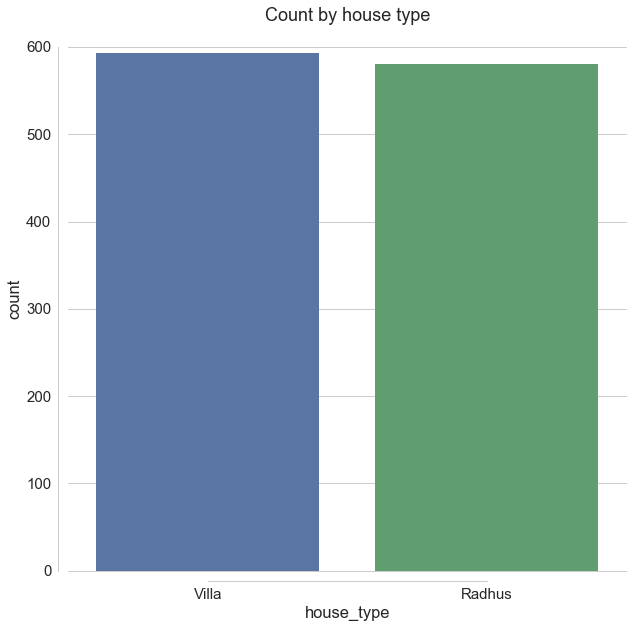

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Count by house type")
ax.get_yaxis().get_major_formatter().set_scientific(False)
#data = df['region'].value_counts()
sns.countplot(x='house_type', data=df)
sns.despine(offset=10, trim=True)
plt.show()

In [43]:
try:
    df = df.drop(['Unnamed: 0', 'price_change_pct'], axis=1)
except:
    pass
df.head(5)

,house_type,address,region,area,sup_area,rooms,land_area,monthly_fee,date_sold,broker,price_change_pct,price
0,Villa,Lilla Slingan 36,Viby,155.0,NaN,6.0,1232.0,NaN,2017-08-29,Fastighetsbyrån Sollentuna,3.0,7700000
1,Radhus,Fjärdingsmansvägen 186,Norrviken,107.0,10.0,5.0,208.0,NaN,2017-08-28,Bjurfors Sollentuna,11.0,4765000
2,Villa,Dianavägen 9,Edsviken,208.0,22.0,9.0,1003.0,NaN,2017-08-28,Susanne Persson Fastighetsförmedling AB,2.0,12700000
3,Villa,Strandpromenaden 9,Norrviken,190.0,103.0,8.0,1389.0,NaN,2017-08-25,Susanne Persson Fastighetsförmedling AB,12.0,12000000
4,Villa,Valkyrievägen 9,Edsviken,198.0,91.0,7.0,1160.0,NaN,2017-08-25,Susanne Persson Fastighetsförmedling AB,1.0,12100000


In [44]:
df = df.dropna(subset=['area'])
df['rooms'].fillna(df['rooms'].mean(), inplace=True)
df['sup_area'].fillna(0, inplace=True)
df['monthly_fee'].fillna(0, inplace=True)
df['land_area'].fillna(0, inplace=True)

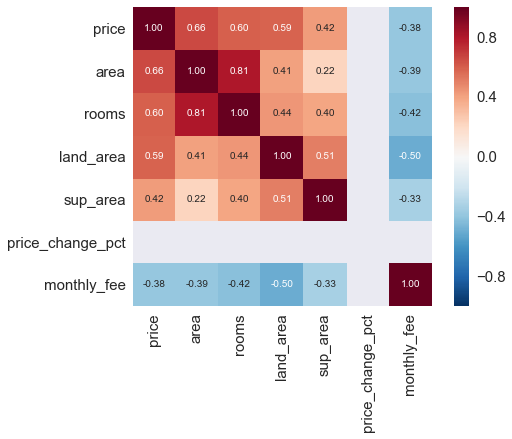

In [45]:
corrmat = df.corr()
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()